# Word2Vec (Google) : Pré-entraînement sur un corpus en français. 

## Modèles  de Word Embeddings 

In [2]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Télécharger les données nécessaires
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Charger les données
file_path = "../tweets_labelled.csv"
df = pd.read_csv(file_path)

### Nettoyage des données

In [5]:
# Supprimer les lien et les emojis
def remove_links(text):
    text = re.sub(r"http\S+", "", text)  # Supprimer les liens
    return text

df['cleaned_text'] = df['Texte'].astype(str).apply(remove_links)

In [6]:
# Fonction pour extraire les mentions sans modifier le reste du texte
def get_mentions(text):
    mentions = re.findall(r"@\S+", text)  # Extraire les mentions
    return mentions

# Fonction pour supprimer les mentions sans affecter les accents
def remove_mentions(text):
    # Utiliser re.sub pour supprimer uniquement les mentions
    return re.sub(r"@\S+", "", text)

# Appliquer sur les données
df['mentions'] = df['cleaned_text'].apply(get_mentions)  # Extraire les mentions
df['cleaned_text'] = df['cleaned_text'].apply(remove_mentions)  # Supprimer les mentions

In [7]:
# afficher les 5 premières lignes
print(df['cleaned_text'].head())

0    le_Parisien :\n"« Je me suis sentie humiliée »...
1    FloPortelli :\n" Ce qui est dingue c’est de po...
2    SAbdelhamid :\n"  Ce qui est dingue c’est qu’o...
3    eve_thefirst :\n"   Personne ne l'empêche de j...
4    ChipeauxMylene :\n"    C est tous à fait ça. D...
Name: cleaned_text, dtype: object


In [8]:
# afficher uniquement les mentions
def mentions(text):
    text = re.findall(r"@\S+", text)  # Trouver les mentions
    return text

# afficher les mentions
print(df['cleaned_text'].apply(mentions).sum())

[]


In [9]:
from collections import Counter
import re

# Fonction pour extraire et compter les caractères spéciaux
def special_characters_count(text):
    # Trouver tous les caractères spéciaux
    special_chars = re.findall(r"[^a-zA-Z0-9\s]", text)
    # Retourner un dictionnaire des occurrences
    return Counter(special_chars)

# Appliquer sur la colonne 'cleaned_text' et agréger les résultats
special_characters_total = df['cleaned_text'].apply(special_characters_count)

# Fusionner tous les comptes en un seul Counter
total_count = Counter()
for count in special_characters_total:
    total_count.update(count)

# Afficher le nombre de chaque caractère spécial
print(total_count)

Counter({'é': 4841, '"': 3955, '.': 3009, ':': 2460, "'": 1993, ',': 1773, '’': 1087, 'à': 991, 'è': 640, '?': 562, '_': 531, '!': 484, '-': 475, 'ê': 405, '#': 329, 'ç': 318, ')': 273, '(': 257, '️': 129, '%': 128, '/': 127, '…': 125, 'ô': 85, 'û': 85, '€': 78, '«': 66, '»': 63, '🤣': 58, '😂': 52, 'É': 49, 'â': 49, '+': 49, 'î': 47, ';': 45, 'ù': 44, 'Ç': 40, '🇷': 34, '&': 30, '🇫': 28, '🤡': 25, '✅': 25, '🤔': 24, '👇': 22, '”': 20, '🙄': 19, '👍': 18, '🚨': 18, '🇪': 18, '➡': 18, '\u200d': 17, '“': 17, 'ï': 16, '=': 16, 'À': 16, '⤵': 15, '*': 15, '😉': 15, '🔴': 15, '⚡': 15, '🇺': 14, '❌': 13, '🏻': 13, '[': 12, ']': 12, '🤦': 12, '🗣': 12, '°': 11, '✈': 11, '👉': 10, '🤷': 10, '🙏': 10, '😅': 10, '⃣': 10, '🚗': 10, '😡': 10, '🇦': 10, '⬇': 9, '😠': 9, '♀': 8, '|': 8, '🙃': 8, 'È': 8, '$': 7, '🇹': 7, 'ë': 7, 'ı': 7, '😘': 6, 'œ': 6, '❤': 6, '♂': 6, '👏': 6, '👎': 6, '🤮': 6, '🚘': 6, '🇸': 6, 'ə': 6, '‘': 5, '🇩': 5, '😤': 5, '💨': 5, '😏': 5, '🇮': 5, '☢': 5, '👻': 5, 'ü': 5, '🇿': 5, '👌': 4, '🧐': 4, '⛽': 4, '📢': 4, '

In [10]:
# Supprimer les caractères spéciaux
def remove_special_characters(text):
    text = re.sub(r"[^a-zA-ZÀ-ÿ\s]", "", text) # Supprimer les caractères spéciaux
    return text

df['cleaned_text'] = df['cleaned_text'].apply(remove_special_characters)

In [11]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0               0
Index                   48
Texte                   48
Media                 1611
Interaction             54
Sujet                   58
Données manquantes     602
A supprimer            101
cleaned_text             0
mentions                 0
dtype: int64


In [12]:
# Supprimer la colonne Media
df.drop(columns=['Media'], inplace=True)

In [13]:
# Si une ligne a un index ou sujet est manquant, supprimez-le
df.dropna(subset=['Index'], inplace=True)
df.dropna(subset=['Sujet'], inplace=True)


In [14]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0              0
Index                   0
Texte                   0
Interaction             0
Sujet                   0
Données manquantes    602
A supprimer           101
cleaned_text            0
mentions                0
dtype: int64


In [15]:
# Supprimer les mots inutiles
stop_words = set(stopwords.words('french'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(text)


df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

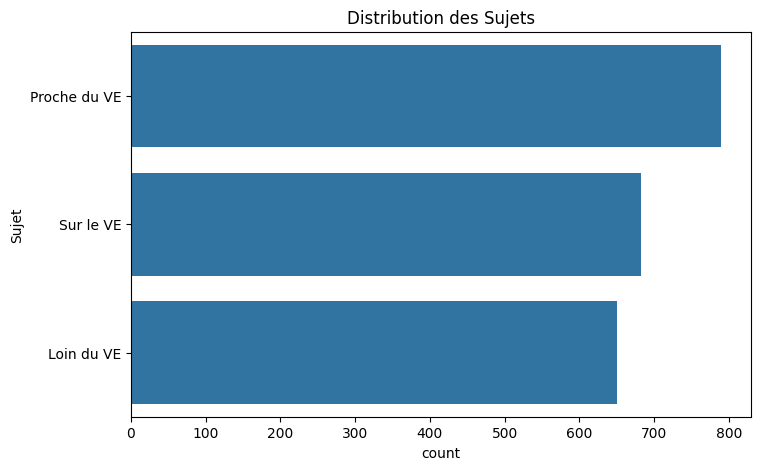

Sujet
Proche du VE    790
Sur le VE       682
Loin du VE      650
Name: count, dtype: int64

In [16]:
# Analyse des catégories (distribution des sujets)
plt.figure(figsize=(8, 5))
sns.countplot(y='Sujet', data=df, order=df['Sujet'].value_counts().index)
plt.title("Distribution des Sujets")
plt.show()

# Analyse des catégories (distribution des sujets) par un tableau
df['Sujet'].value_counts()


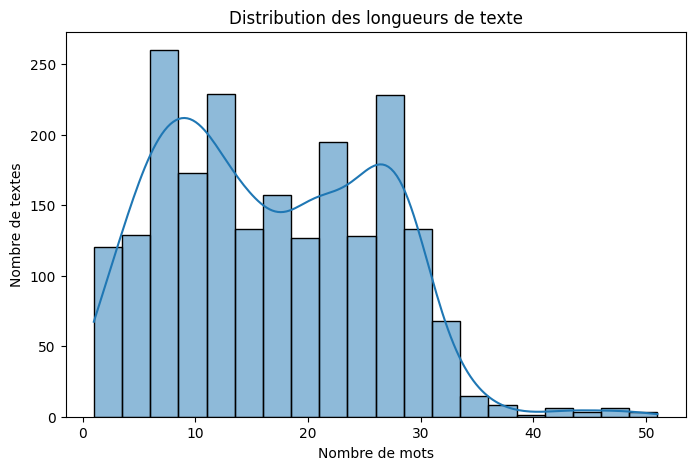

In [17]:
# Analyse des longueurs de texte
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title("Distribution des longueurs de texte")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de textes")
plt.show()

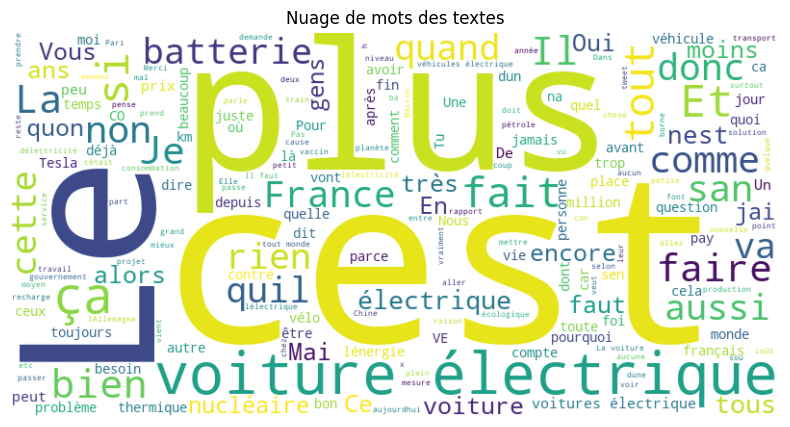

In [18]:
# Nuage de mots (WordCloud)
all_text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des textes")
plt.show()

In [19]:
# Fréquences des mots
from collections import Counter

all_words = " ".join(df['cleaned_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)

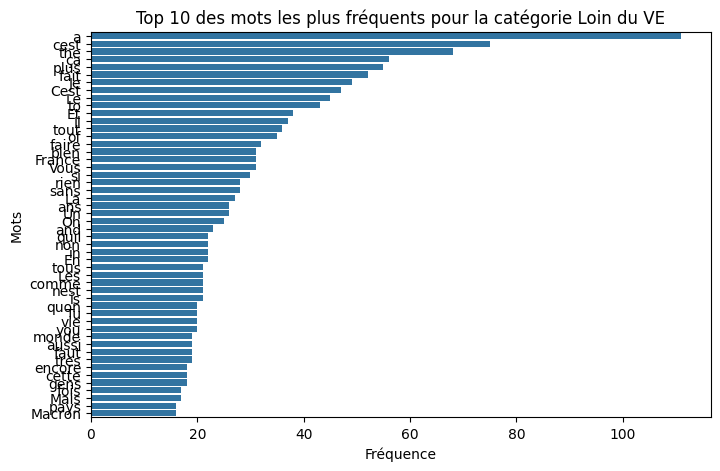

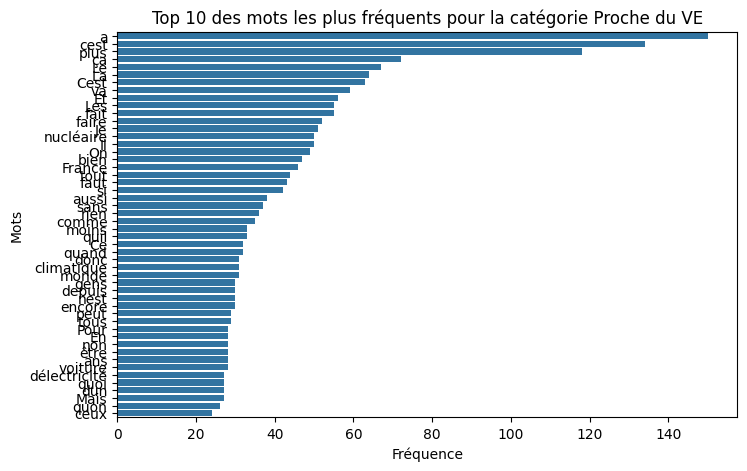

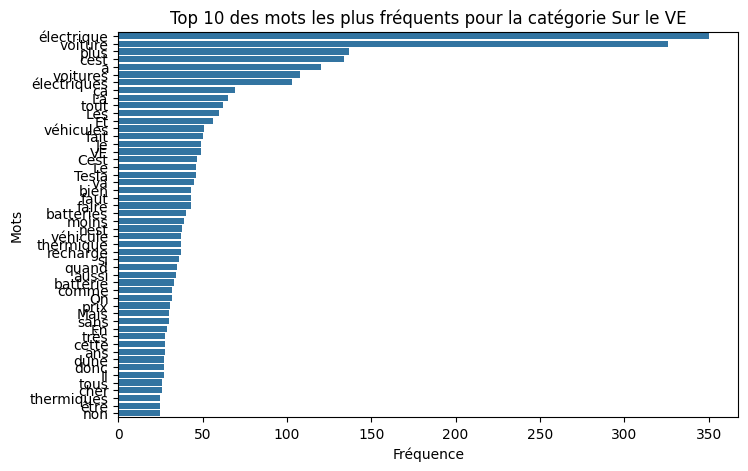

In [20]:
# Afficher les mots les plus fréquents par catégorie
categories = df['Sujet'].unique()

for category in categories:
    text = " ".join(df[df['Sujet'] == category]['cleaned_text']).split()
    word_freq = Counter(text)
    common_words = word_freq.most_common(50)

    if common_words:  # Check if common_words is not empty
        words, counts = zip(*common_words)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f"Top 10 des mots les plus fréquents pour la catégorie {category}")
        plt.xlabel("Fréquence")
        plt.ylabel("Mots")
        plt.show()

In [21]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Tokeniser les textes nettoyés
df['tokens'] = df['cleaned_text'].apply(lambda x: word_tokenize(x.lower()))

# Entraîner le modèle Word2Vec
sentences = df['tokens'].tolist()  # Obtenir toutes les phrases tokenisées
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Mots clés pour détecter les tweets sur les voitures électriques
keywords = [
    "électricité", "voiture", "voitures", "véhicules", "véhicule", 
    "tesla", "recharge", "batterie", "batteries", "thermique", 
    "thermiques", "hybride", "hybrides", "bornes", "électrique", 
    "électriques"
]

# Fonction pour calculer la similarité moyenne entre les mots d'un tweet et les mots-clés
def calculate_similarity(tweet_tokens, model, keywords):
    similarities = []
    for word in tweet_tokens:
        if word in model.wv:  # Vérifiez si le mot est dans le vocabulaire du modèle
            word_similarities = [model.wv.similarity(word, keyword) for keyword in keywords if keyword in model.wv]
            if word_similarities:
                similarities.append(max(word_similarities))
    return np.mean(similarities) if similarities else 0

# Calculer la similarité pour chaque tweet
df['similarity'] = df['tokens'].apply(lambda x: calculate_similarity(x, model, keywords))

In [22]:
# Filtrer les tweets pertinents (similarité > seuil, par exemple 0.5)
relevant_tweets = df[df['similarity'] > 0.6]

# Afficher les tweets pertinents
print(relevant_tweets[['cleaned_text', 'similarity']])

                                           cleaned_text  similarity
4     ChipeauxMylene C tous fait ça Dans sport a règ...    0.681033
8     WestRiseAgain Les autorités font tout empêcher...    0.620568
42     Remymgv Pour fois quune voiture électrique belle    0.764285
46            Splainte Le prix usage cest seul problème    0.688679
50    DallaireBitcoin Selon estce quil plus quune cr...    0.616576
...                                                 ...         ...
2162  Emilien Et co quon va supprimer va être rempla...    0.676442
2163  laydgeur Je sais si cest ironique donc cas où ...    0.655269
2165                               laydgeur Je vois non    0.717559
2166  BFMTV Coupures courant comment savoir si foyer...    0.648932
2171  fredbourget Comme si cavelà prêt entendre parl...    0.625137

[501 rows x 2 columns]


In [23]:
# Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X = df['cleaned_text']
y = df['Sujet']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entraîner un classificateur RandomForest
clf = RandomForestClassifier()
clf.fit(X_train_tfidf, y_train)

# Prédire les catégories
y_pred = clf.predict(X_test_tfidf)

# Afficher les résultats
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

  Loin du VE       0.64      0.82      0.72       129
Proche du VE       0.73      0.62      0.67       154
   Sur le VE       0.91      0.83      0.87       142

    accuracy                           0.75       425
   macro avg       0.76      0.76      0.75       425
weighted avg       0.76      0.75      0.75       425

Accuracy: 0.7505882352941177


In [24]:
# xgbouster classifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encoder les labels textuels en numériques
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Entraîner un classificateur XGBoost
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train_tfidf, y_train_encoded)

# Prédire les catégories
y_pred_xgb_encoded = clf_xgb.predict(X_test_tfidf)

# Décoder les prédictions pour obtenir les labels textuels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Afficher les résultats
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


              precision    recall  f1-score   support

  Loin du VE       0.62      0.72      0.67       129
Proche du VE       0.65      0.63      0.64       154
   Sur le VE       0.91      0.81      0.86       142

    accuracy                           0.72       425
   macro avg       0.73      0.72      0.72       425
weighted avg       0.73      0.72      0.72       425

Accuracy: 0.7176470588235294


In [25]:
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Diviser les données en ensembles d'entraînement et de test
X = df['cleaned_text'].tolist()
y = df['Sujet'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', 
    num_labels=len(df['Sujet'].unique())
)

# Fonction pour tokeniser les données
def tokenize_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# Préparer les données pour Hugging Face Dataset
train_data = Dataset.from_dict({'text': X_train, 'label': y_train})
test_data = Dataset.from_dict({'text': X_test, 'label': y_test})

# Tokeniser les données
train_data = train_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

# Définir les colonnes nécessaires pour Trainer
train_data = train_data.rename_column("label", "labels")
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_data = test_data.rename_column("label", "labels")
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Créer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',  # Dossier pour sauvegarder les checkpoints
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',  # Dossier pour les fichiers de logs
    logging_steps=10,
    evaluation_strategy='epoch',
)

# Créer un objet Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

# Entraîner le modèle
trainer.train()

# Évaluer le modèle
predictions = trainer.predict(test_data)
y_pred = np.argmax(predictions.predictions, axis=1)

# Afficher les résultats
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


/Users/mathispappo/Documents/Engineering-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 425/425 [00:00<00:00, 1409.87 examples/s]
/Users/mathispappo/Documents/Engineering-Project/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/639 [00:00<?, ?it/s]

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.